In [66]:
import tensorflow as tf
from tensorflow.keras import layers, utils

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import os
import math

**Generate Datasets**

In [67]:
# mount google drive
# original image dataset: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors

from google.colab import drive

drive.mount('/content/gdrive')
dir = "/content/gdrive/MyDrive/Colab Notebooks/rps/images/"
categories = ["rock", "paper", "scissors"]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [85]:
width = 182 # original : 300
height = 128 # original: 200
input_shape = (height, width, 3)

def get_image_to_array(image_path):
  image = Image.open(image_path)
  image = image.resize((width, height))

  im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
  im_arr = im_arr.reshape((image.size[1], image.size[0], 3))

  return im_arr

def get_data():
  x_images = []
  y_categories = []
  for index, category in enumerate(list(categories)):
    for file_name in os.listdir(dir+category):
      image_path = dir + category + "/" + file_name
      x_images.append(get_image_to_array(image_path))
      y_categories.append(index)

  return np.array(x_images), np.array(y_categories)

Image count: 2188
Image matrix: 3*182*128


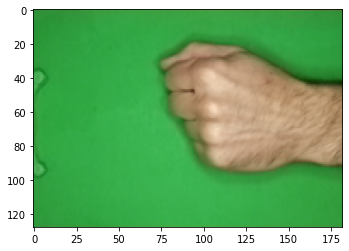

In [73]:
images, categories = get_data()

print("Image count:", len(images))
print("Image matrix: %d*%d*%d" %(len(images[0][0][0]),len(images[0][0]),len(images[0])))
plt.imshow(images[0])

In [81]:
train_ratio = 0.7
split_index = math.floor(len(images) * 0.7)

x_train, x_test = images[:split_index], images[split_index:]
y_train, y_test = categories[:split_index], categories[split_index:]

x_train = x_train.astype('float32')
x_train /= 255 # convert RGB -> 0..1

y_train = utils.to_categorical(y_train, len(categories))
y_test = utils.to_categorical(y_test, len(categories))

print('count')
print(' x_train: %d | x_test: %d' %(x_train.shape[0], x_test.shape[0]))
print(' y_train: %d | y_test: %d' %(y_train.shape[0], y_test.shape[0]))

count
 x_train: 1531 | x_test: 657
 y_train: 1531 | y_test: 657


**Model design**

In [88]:
learning_rate = 0.01

batch_size = 10
epochs = 10
validation_split = 0.2

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [87]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(16, (5,5), strides=(1,1), padding='same',
                        activation='relu', input_shape=input_shape, 
                        name='conv1'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2), padding='same',
                        name='pool1'))
model.add(layers.Conv2D(32, (5,5), strides=(1,1), padding='same', 
                        activation='relu', input_shape=input_shape, 
                        name='conv2'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2), padding='same', 
                        name='pool2'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(categories), activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(learning_rate=learning_rate), 
              metrics=['accuracy'])

model.summary()

In [89]:
hist = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=[early_stop],
    shuffle=True,
    verbose=1
)

score = model.evaluate(x_test, y_test, verbose=1)
print(' - test_loss:', score[0], ' - test_acc:', score[1])

Epoch 1/10
123/123 [==============================] - 48s 380ms/step - loss: 2.7458 - accuracy: 0.6495 - val_loss: 4.9929 - val_accuracy: 0.5831
Epoch 2/10
123/123 [==============================] - 47s 385ms/step - loss: 0.4362 - accuracy: 0.8227 - val_loss: 5.5008 - val_accuracy: 0.6873
Epoch 3/10
123/123 [==============================] - 45s 362ms/step - loss: 0.3657 - accuracy: 0.8489 - val_loss: 6.1497 - val_accuracy: 0.4365
Epoch 4/10
21/21 [==============================] - 6s 257ms/step - loss: 4813.5200 - accuracy: 0.0000e+00
 - test_loss: 4813.52001953125  - test_acc: 0.0


<Figure size 1080x216 with 0 Axes>

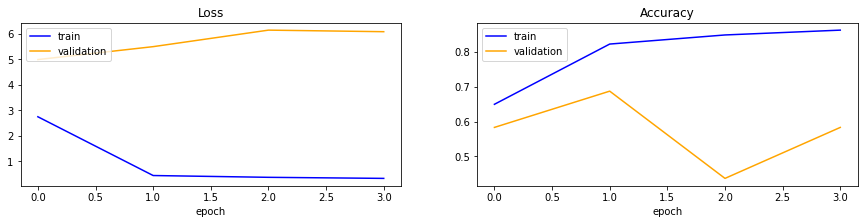

<Figure size 1080x216 with 0 Axes>

In [144]:
plt.figure(figsize=(15,3))

plt_loss = plt.subplot(1,2,1)

plt_loss.plot(hist.history['loss'], 'blue', label='train')
plt_loss.plot(hist.history['val_loss'], 'orange', label='validation')
plt_loss.set_title('Loss')
plt_loss.set_xlabel('epoch')
plt_loss.legend(loc='upper left')

plt_accuracy = plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], 'blue', label='train')
plt_accuracy.plot(hist.history['val_accuracy'], 'orange', label='validation')
plt_accuracy.set_title('Accuracy')
plt_accuracy.set_xlabel('epoch')
plt_accuracy.legend(loc='upper left')
plt.figure(figsize=(15,3))